In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist

import ot

import geomstats
from geomstats.geometry.spd_matrices import SPDMatrices

from dtmrpy import DT_GMM

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict, LeaveOneOut
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

INFO: Using numpy backend


In [2]:
class dtgmm:
    def __init__(self, weights, locations):
        assert weights.shape[0] == locations.shape[0]
        self.weights = weights
        self.locations = locations
     
    def means_(self):
        return self.locations[:,:3]
    
    def covariances_(self):
        C = self.locations[:,3:]
        return np.array([C[:,0],C[:,1]/2,C[:,2]/2,C[:,1]/2,C[:,3],C[:,4]/2,C[:,2]/2,C[:,4]/2,C[:,5]]).T.reshape(-1,3,3)
        
    def plot_gmm(self):
        w = self.weights/max(self.weights)
        x,y,z = self.locations[:,0],self.locations[:,1],self.locations[:,2]
        c = np.array([self.locations[:,3],self.locations[:,6],self.locations[:,8]]).T
        c=c/(np.sum(c,1).reshape(-1,1))
 
        for i in range(w.shape[0]):
            plt.plot(x[i],y[i],z[i],'.',c=c[i],alpha = w[i])
            
        # plt.gca().scatter(x,y,z,s=8,c=c, alpha = w) # much faster, but renders differently

def DT_GMM_to_dtgmm(DT_GMM):
    w = DT_GMM.weights_.reshape(-1)
    weights = w/sum(w)
    
    x = DT_GMM.means_
    x = x-np.mean(x,0)
    cov_temp = geomstats.geometry.spd_matrices.SPDMatrices(3).projection(DT_GMM.covariances_)
    C = (cov_temp.reshape(-1,9)[:,np.array([0,1,2,4,5,8])])*(np.array([1,2,2,1,2,1]).reshape(1,-1))   
    locations = np.concatenate([x,C],1)
    
    return dtgmm(weights, locations)

def dtgmm_to_DT_GMM(dtgmm):
    weights_ = dtgmm.weights
    means_ = dtgmm.locations[:,:3]
    dtgmm.covariances_
    return DT_GMM(weights_,means_,covarinaces_)

In [3]:
class free_support_barycenter(dtgmm):
    
    def __init__(self,barycenter=None, N=200, lr=0.0000001):
        self.lr=lr #learning rate for weights update
        
        if barycenter==None:
            init_weights = np.ones(N)/N
            x = np.zeros(3)+np.random.normal(size=(N,3))
            cov_temp = geomstats.geometry.spd_matrices.SPDMatrices(3).random_point(N)
            C = (cov_temp.reshape(-1,9)[:,np.array([0,1,2,4,5,8])])*(np.array([1,2,2,1,2,1]).reshape(1,-1)) 
            init_locations = np.concatenate([x,C],1)
            
            super().__init__(init_weights, init_locations)
            self.N = N
        
        else:
            super().__init__(barycenter.weights, barycenter.locations)
            self.N = barycenter.weights.shape[0]
               
    def get_barycentric_projection_embedding(self, measures_list):
        self.M_list = [np.square(cdist(self.locations,measure.locations)) for measure in measures_list]
        #calculate optimal couplings and optimal dual variables
        result_list = [ot.emd(self.weights,measure.weights,self.M_list[i],log=True) for i, measure in enumerate(measures_list)]
        #store optimal couplings
        self.Pi_list = [result[0] for result in result_list]
        #store optimal dual variables - center_ot_dual can probably just be replaced with result[1]['u']-np.mean(result[1]['u'])
        self.alpha_list = [ot.lp.center_ot_dual(result[1]['u'],result[1]['v'])[0] for result in result_list]
        #calculate and store barycentric projection locations
        self.embedding = np.array([(measures_list[i].locations.T@self.Pi_list[i].T@np.diag(1/self.weights.reshape(-1))).T for i in range(len(measures_list))])

    def weights_update(self):
        #get subgradient
        alpha = np.mean(np.array(self.alpha_list),0)
        #calculate subgradient update
        a_star = self.weights+(self.lr*alpha.reshape(1,-1))
        #project a_star into (interior of) probability simplex
        a_star[a_star<0]=1e-8
        a = a_star/np.sum(a_star)

        return a.reshape(-1)
        
    def free_support_barycenter_update(self, measures_list):
        self.get_barycentric_projection_embedding(measures_list)
        self.locations = np.mean(self.embedding,0)
        self.weights = self.weights_update()
        # print(np.mean(np.square(np.linalg.norm(barycenter.pseudo_log(),axis=1))))
        
    def pseudo_log(self):
        #calculate vector field representations
        return (self.embedding - self.locations).reshape(-1,self.N*9)
    
    def fit(self, measures_list, K=10, plot_steps=False):
        
        for i in range(K):
            self.free_support_barycenter_update(measures_list)
            
            if plot_steps:
                plt.figure().add_subplot(projection='3d')
                barycenter.plot_gmm()
                plt.gca().view_init(35,135)
                plt.show()
        

In [4]:
tract_names = pd.read_csv("D:\\DTMRI\\GTP\\roi_names.csv", header=None)[0].values.astype(str)
tract_names = list(tract_names[:10])+list(tract_names[14:16])+list(tract_names[-2:])+['Cerebellum_L', 'Cerebellum_R']

In [5]:
df_m = pd.read_pickle('D:\\DTMRI\\ADNI\\dtmri_dataframe_ADNI_M_276.pkl')
df_f = pd.read_pickle('D:\\DTMRI\\ADNI\\dtmri_dataframe_ADNI_F_318.pkl')

df = pd.concat((df_m,df_f))
df = df.dropna(thresh=len(tract_names),axis=0)
df.reset_index(inplace=True)
df

,index,sid,label,sex,age,fib_files,Cingulum_Frontal_Parietal_L,Cingulum_Frontal_Parietal_R,Cingulum_Parahippocampal_L,Cingulum_Parahippocampal_R,...,Cingulum_Parolfactory_L,Cingulum_Parolfactory_R,Fornix_L,Uncinate_Fasciculus_L,Uncinate_Fasciculus_R,Cerebellum_L,Cerebellum_R,Cingulum_Frontal_Parahippocampal_L,Cingulum_Frontal_Parahippocampal_R,Fornix_R
0,0,941_S_4365,0,M,86,C:\Users\micha\OneDrive - Florida State Univer...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001895F2D...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896034...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896039...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896338...,...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896647...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000189664E...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896752...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896759...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000189695D...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896E57...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896E60...,NaN,NaN,NaN
1,1,941_S_4292,0,M,77,C:\Users\micha\OneDrive - Florida State Univer...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001895F30...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896034...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896039...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896338...,...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896647...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000189664E...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896752...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896759...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000189695D...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896E57...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896E60...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001897E39...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001897E3B...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001897E3F...
2,5,301_S_6592,1,M,72,C:\Users\micha\OneDrive - Florida State Univer...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001895F30...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896034...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896039...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896338...,...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896647...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000189664E...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896752...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896759...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000189695D...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896E57...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896E60...,NaN,NaN,<dtmrpy.dtmrpy.DT_GMM object at 0x000001897E3F...
3,6,301_S_6326,0,M,76,C:\Users\micha\OneDrive - Florida State Univer...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001895F30...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896034...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896039...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896338...,...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896647...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000189664E...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896752...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896759...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000189695D...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896E57...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896E60...,NaN,<dtmrpy.dtmrpy.DT_GMM object at 0x000001897E3B...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001897E3F...
4,7,177_S_6448,0,M,68,C:\Users\micha\OneDrive - Florida State Univer...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001895F30...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896034...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896039...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896338...,...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896647...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000189664E...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896752...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896759...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000189695D...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896E57...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001896E60...,NaN,<dtmrpy.dtmrpy.DT_GMM object at 0x000001897E3B...,<dtmrpy.dtmrpy.DT_GMM object at 0x000001897E3F...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [6]:
df_x = df[df.columns[3:5]]
sex_mapping = {'M': 0, 'F': 1}
df_x['sex'] = df_x['sex'].map(sex_mapping)

# Convert DataFrame to NumPy array
covariates = df_x.to_numpy()

C:\Users\micha\AppData\Local\Temp\ipykernel_12848\3396896089.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x['sex'] = df_x['sex'].map(sex_mapping)


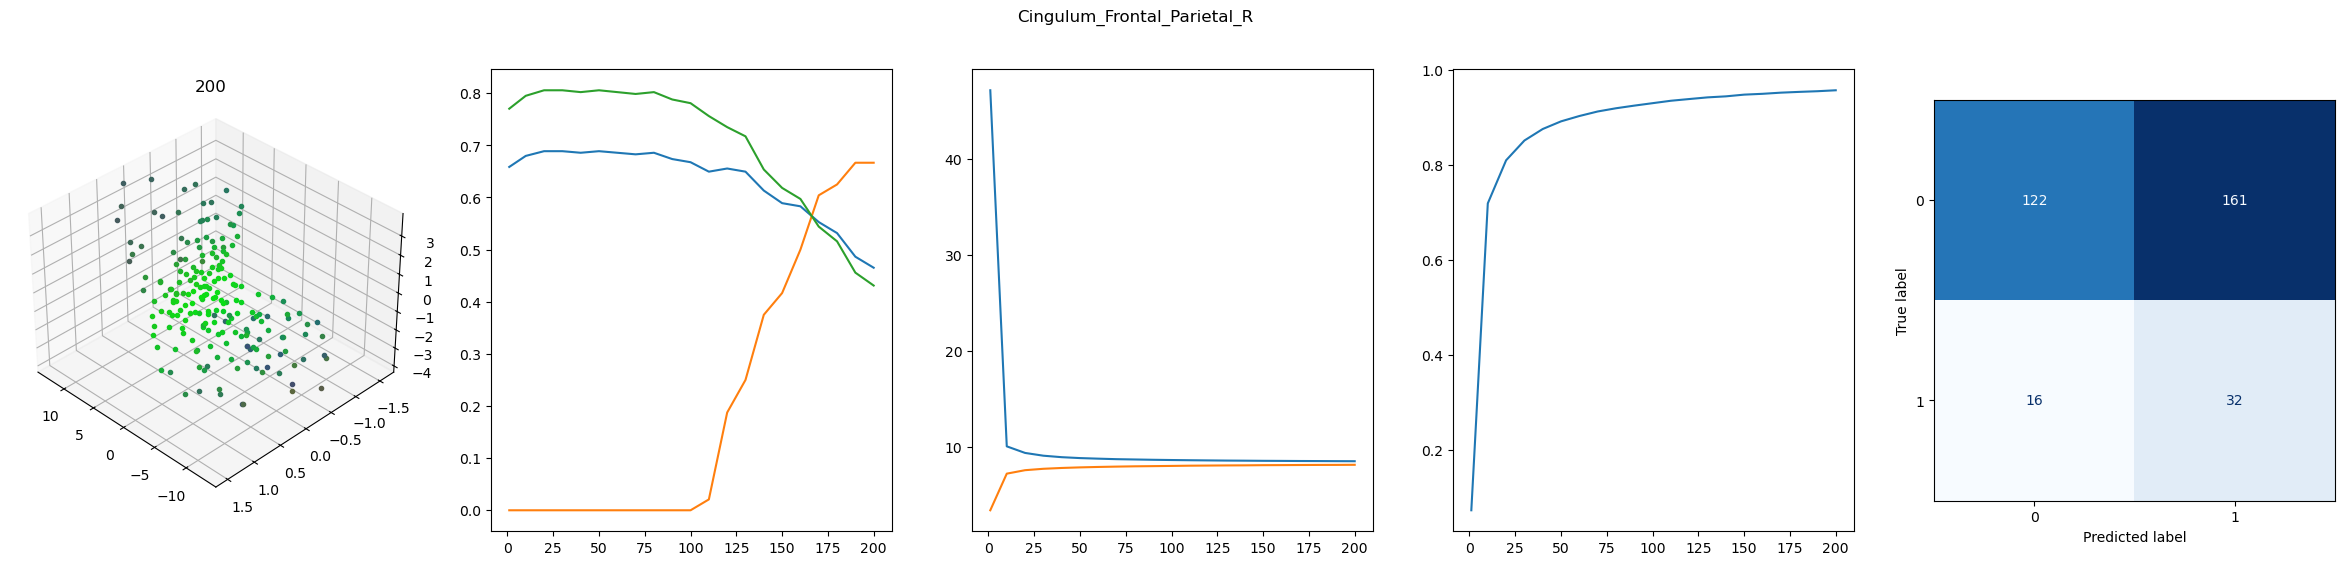

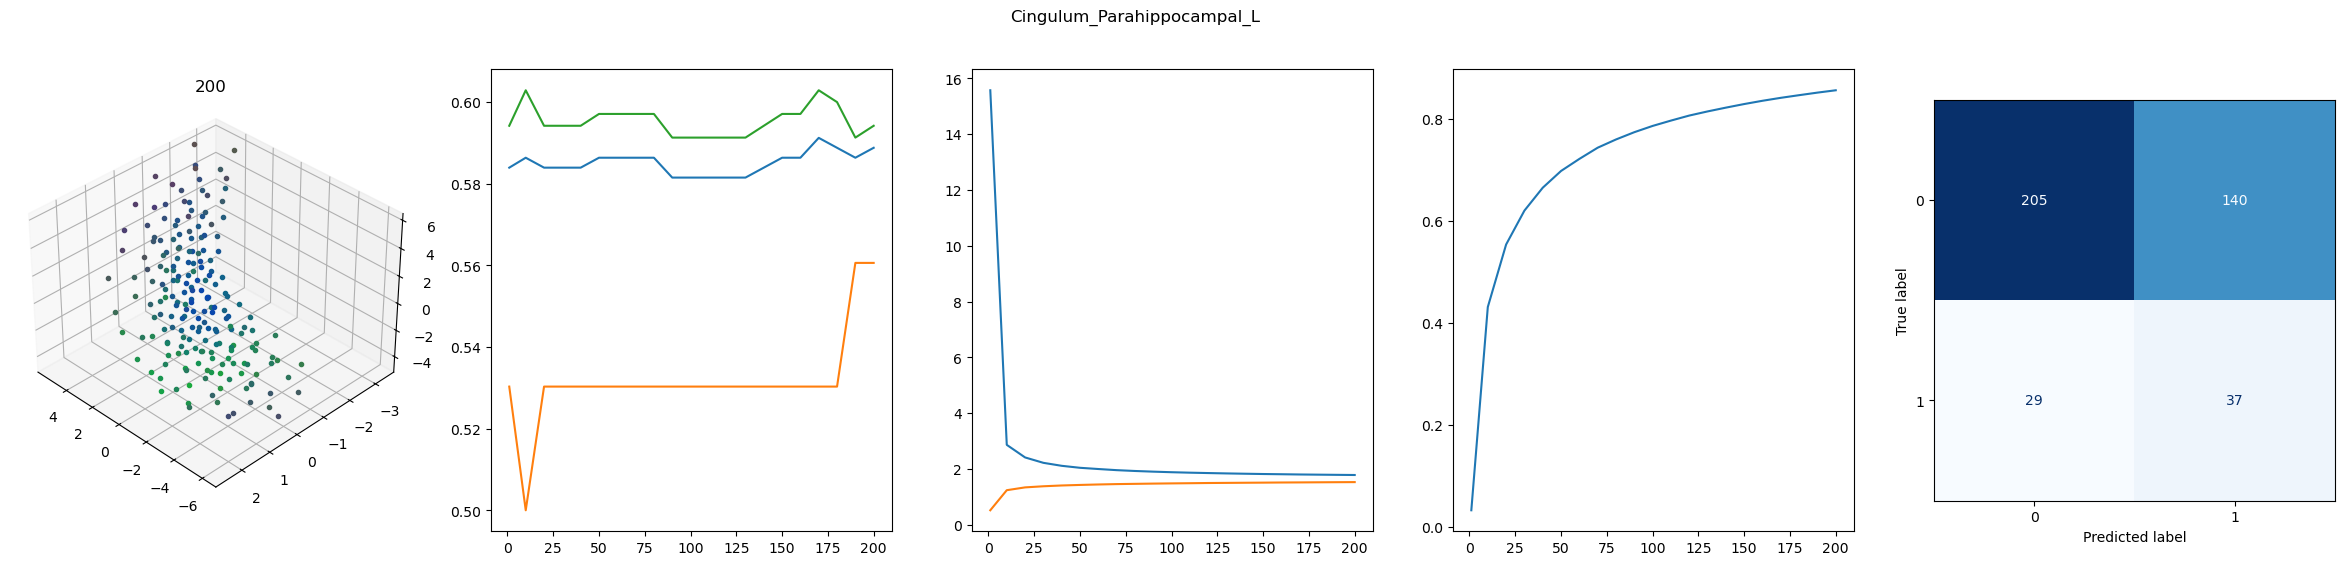

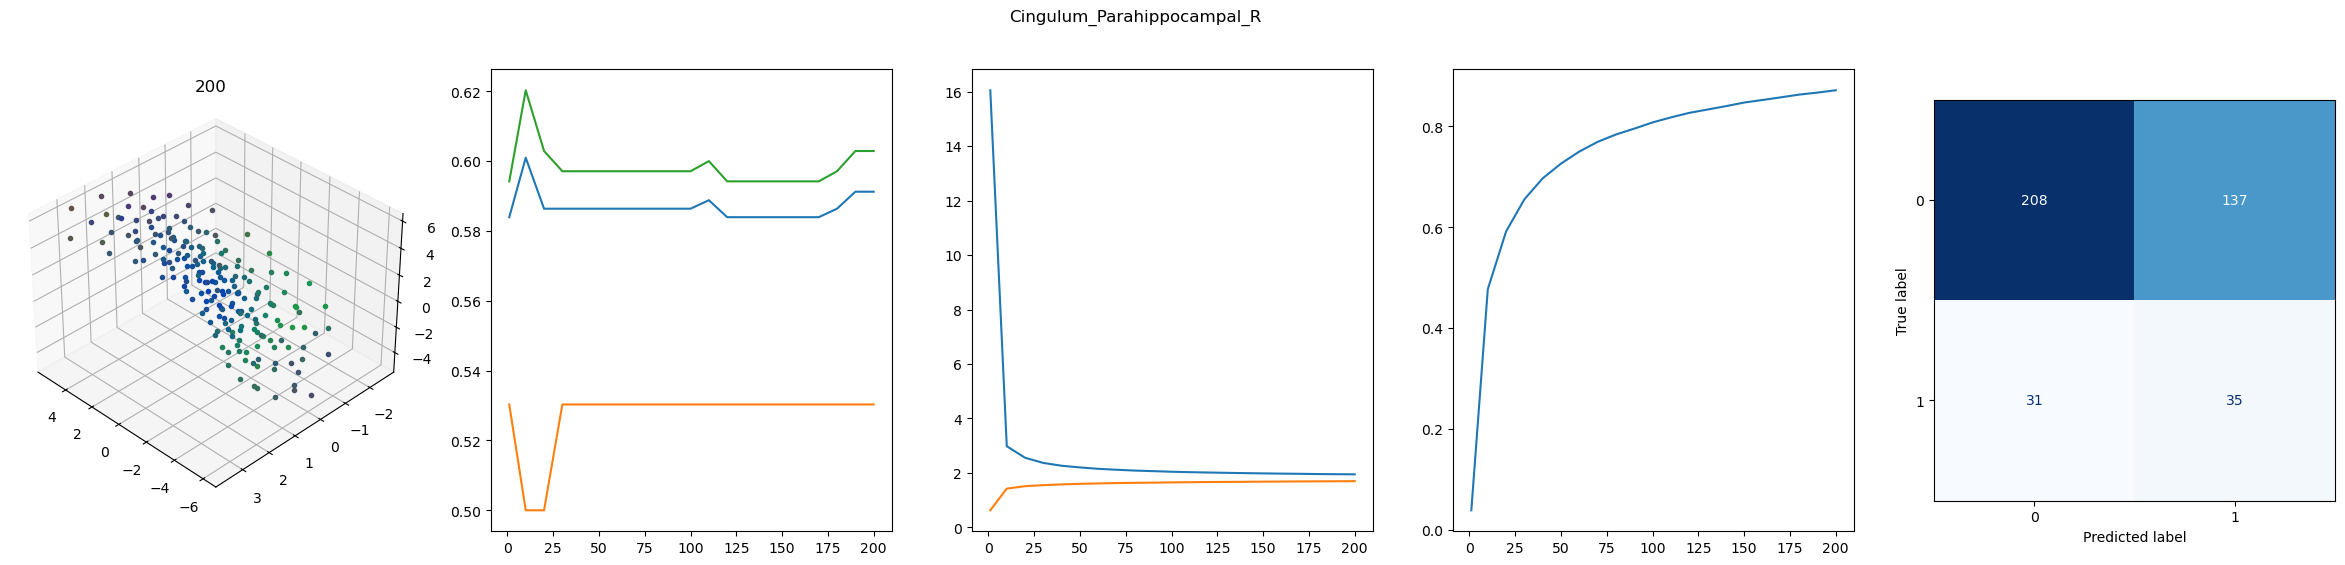

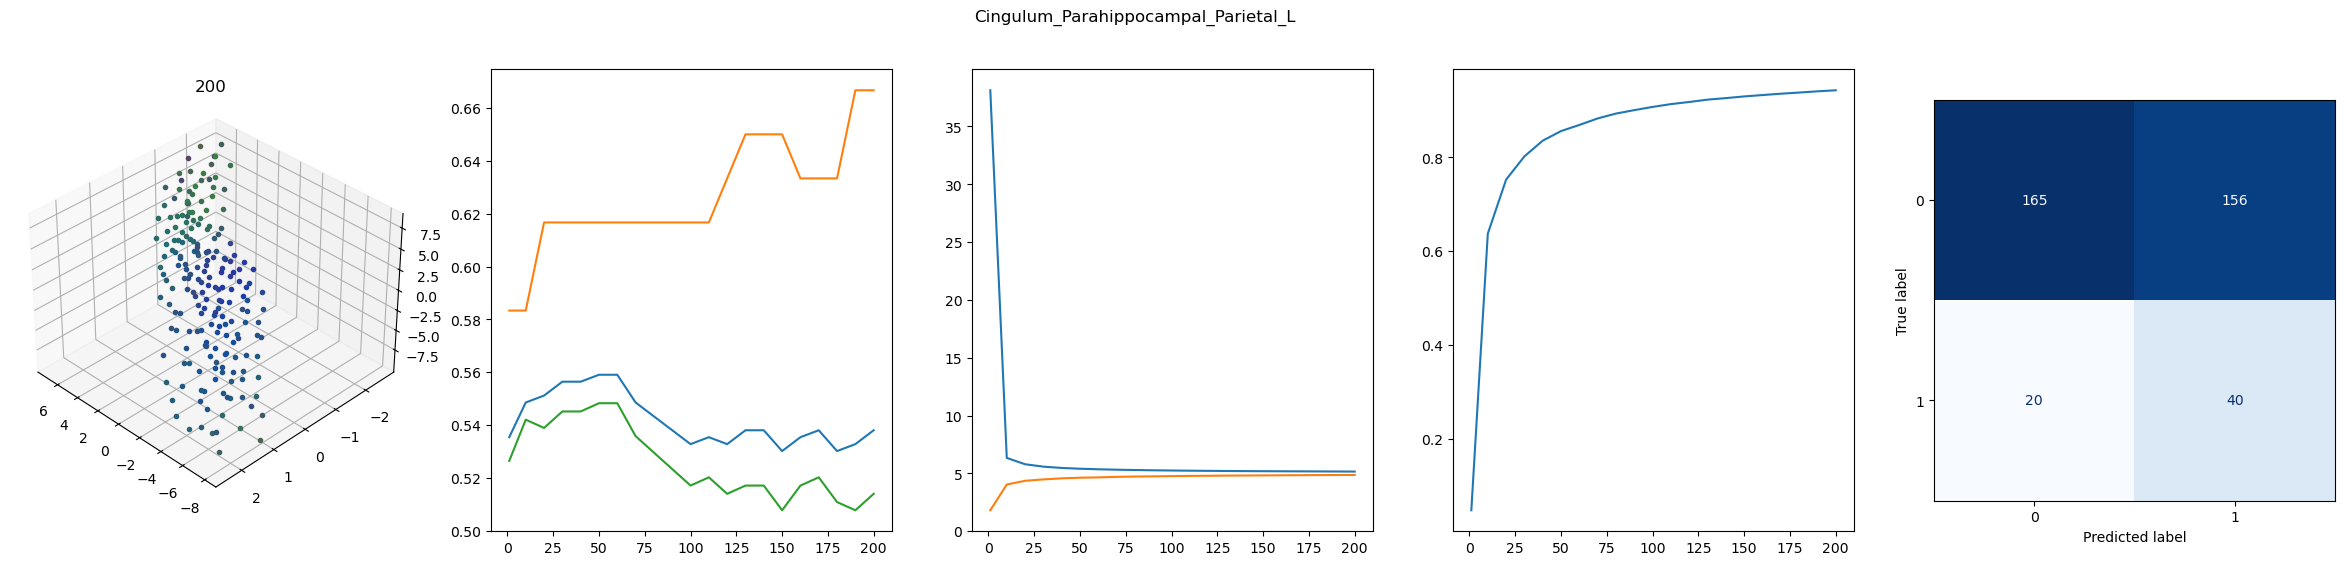

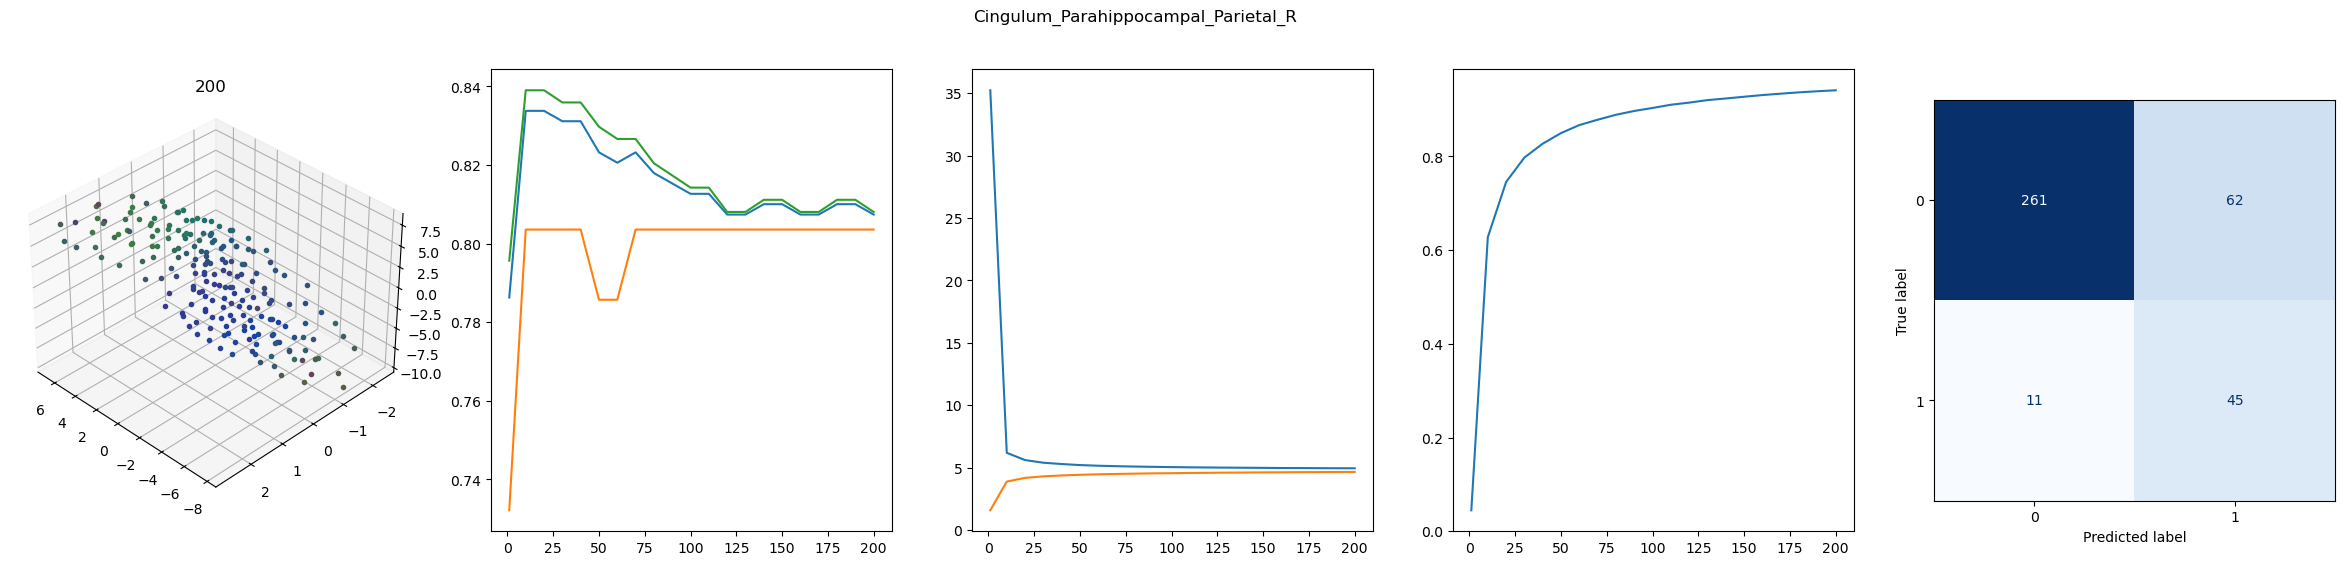

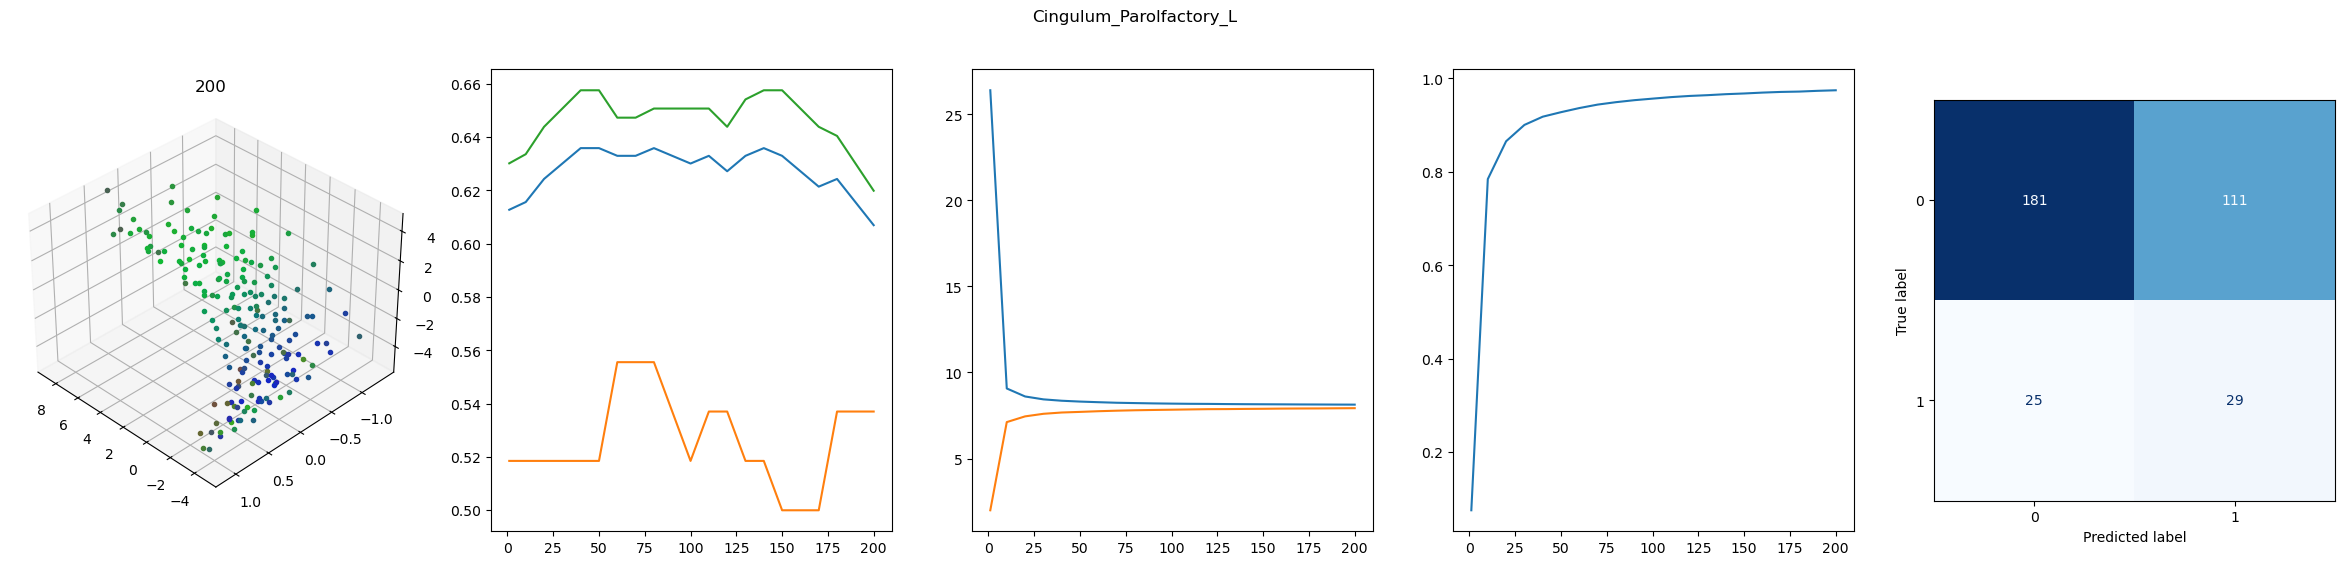

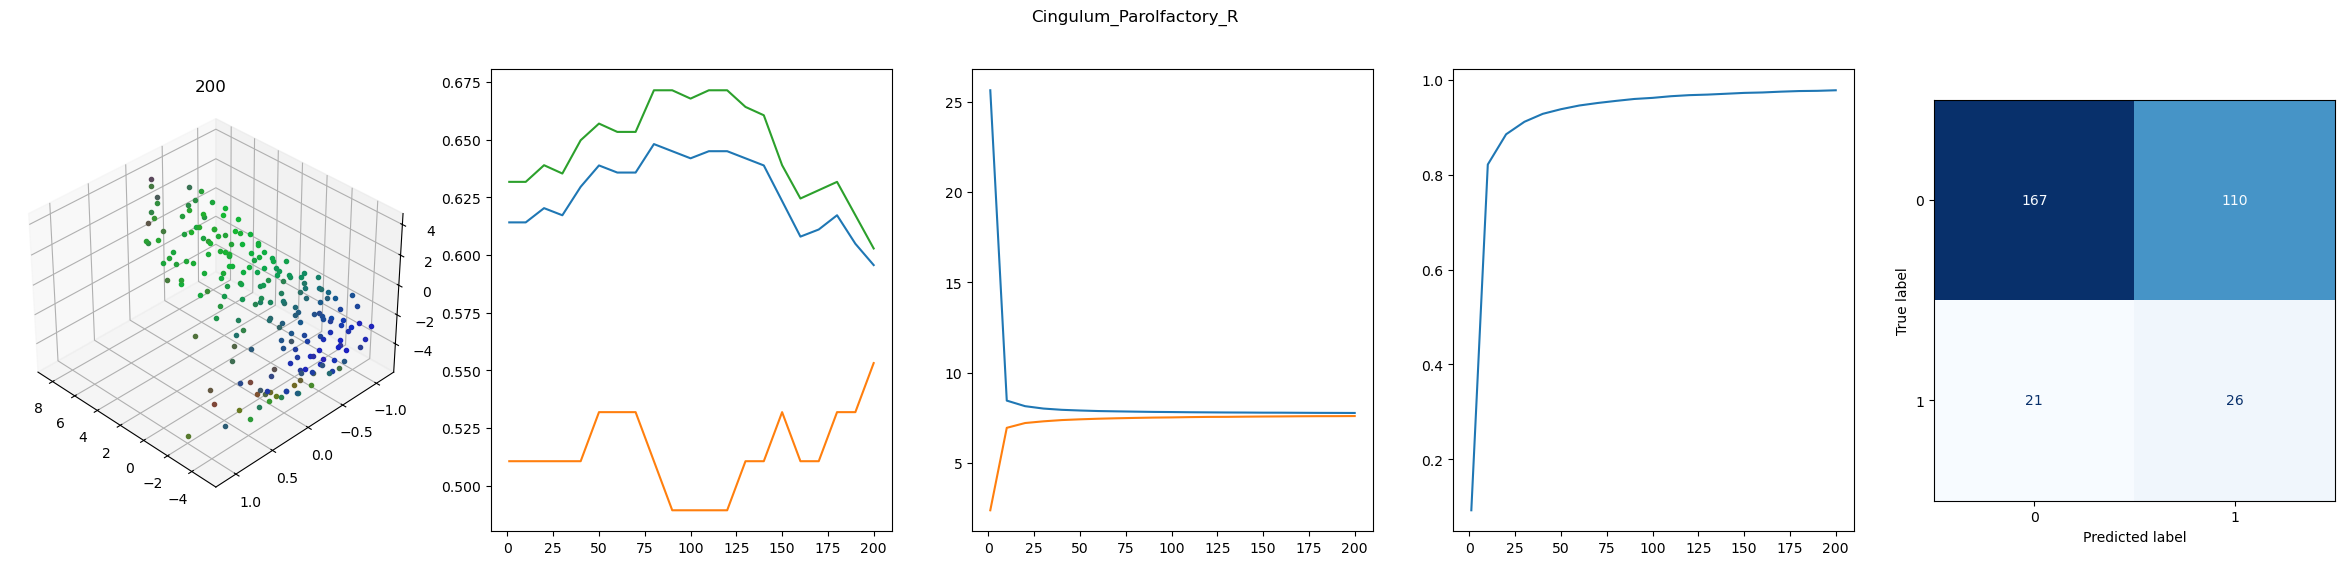

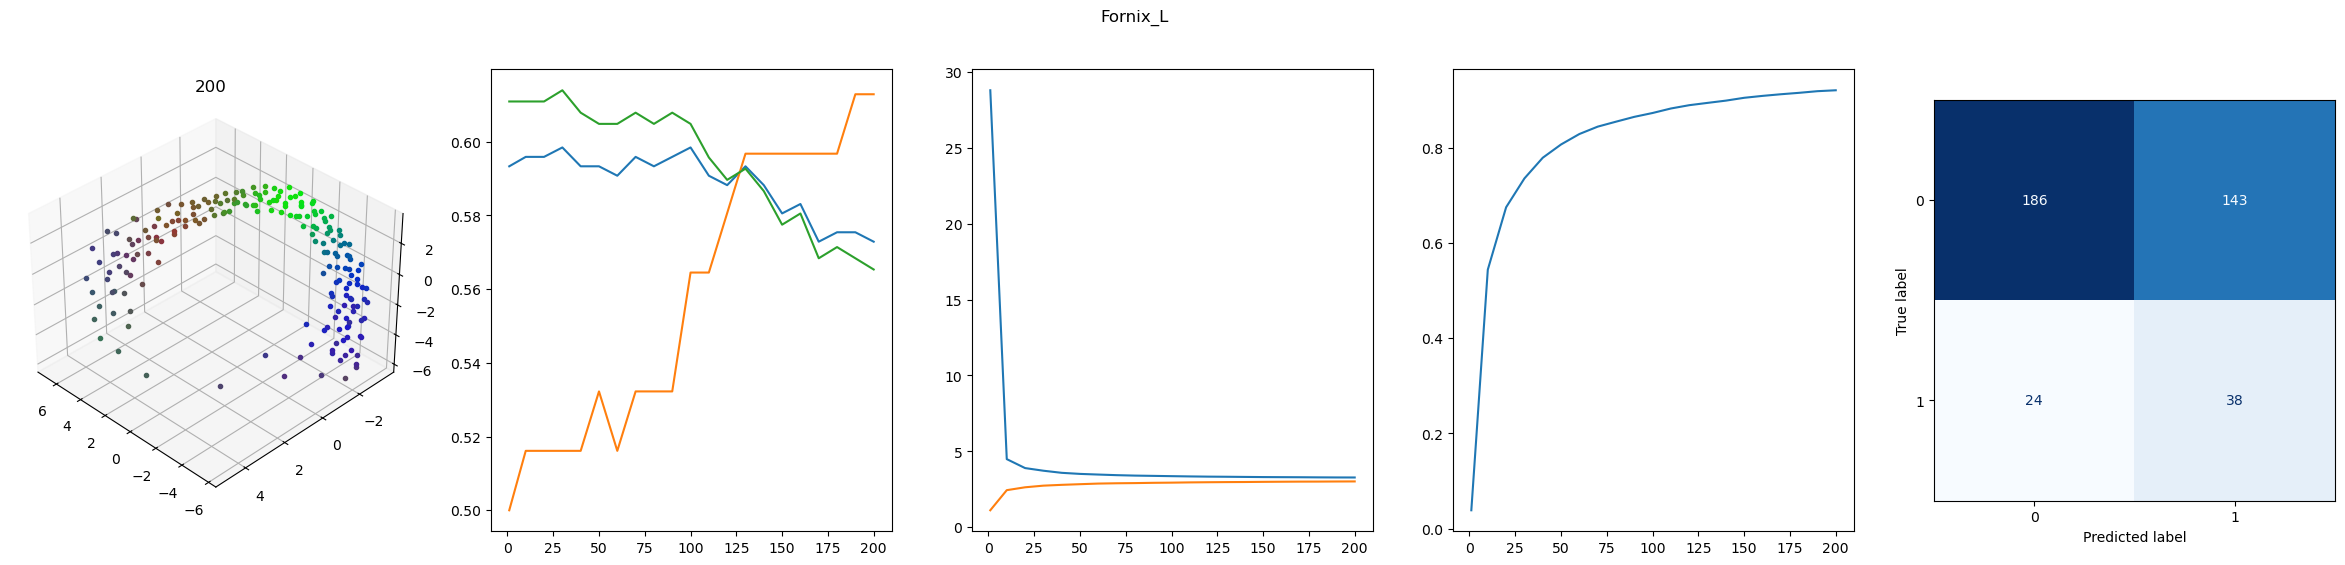

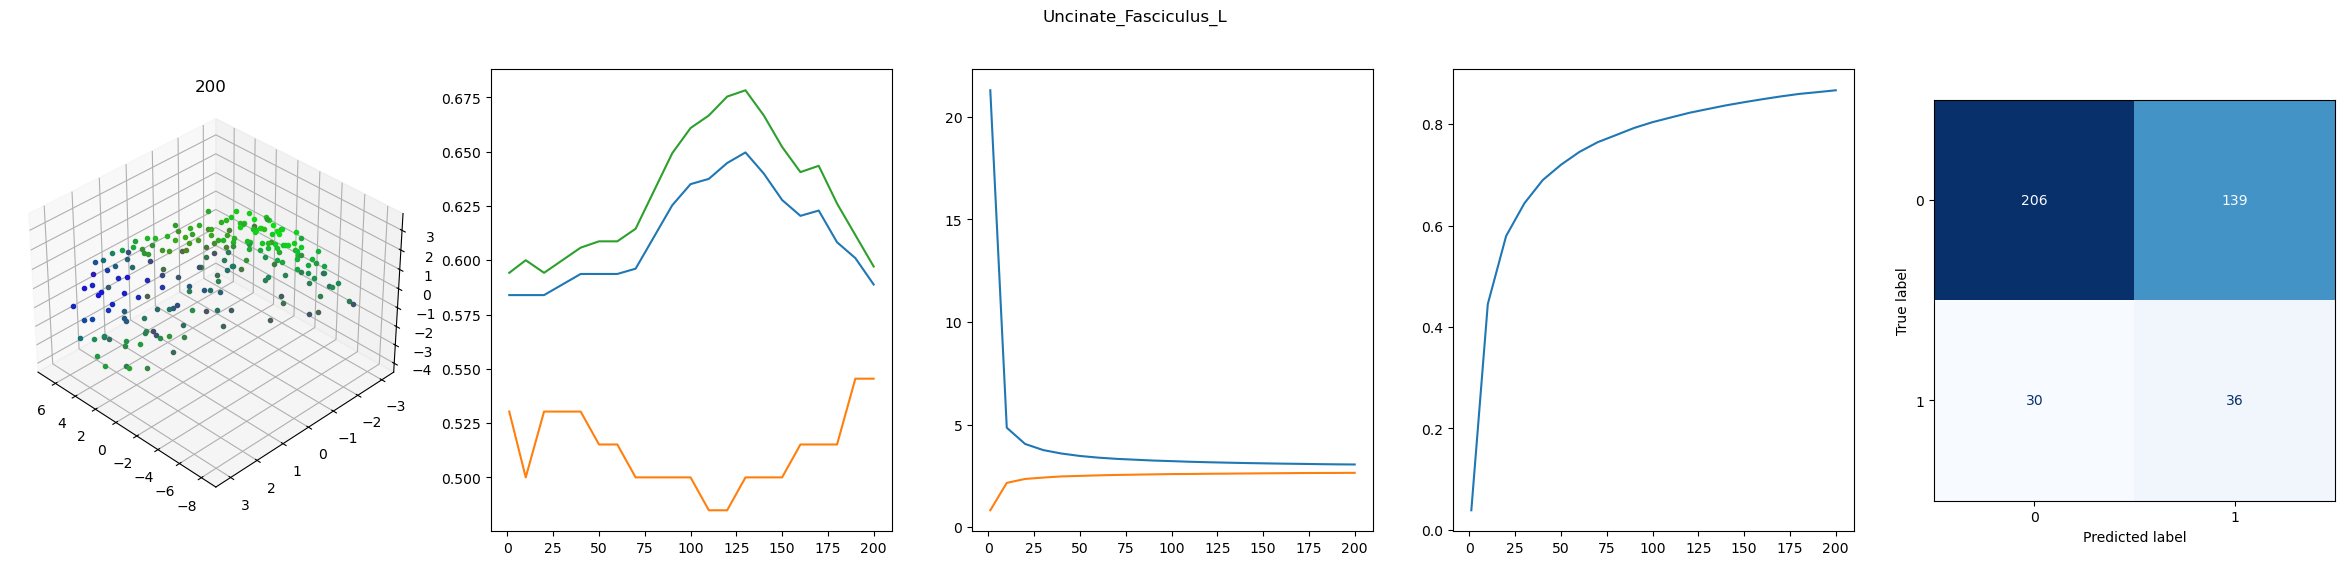

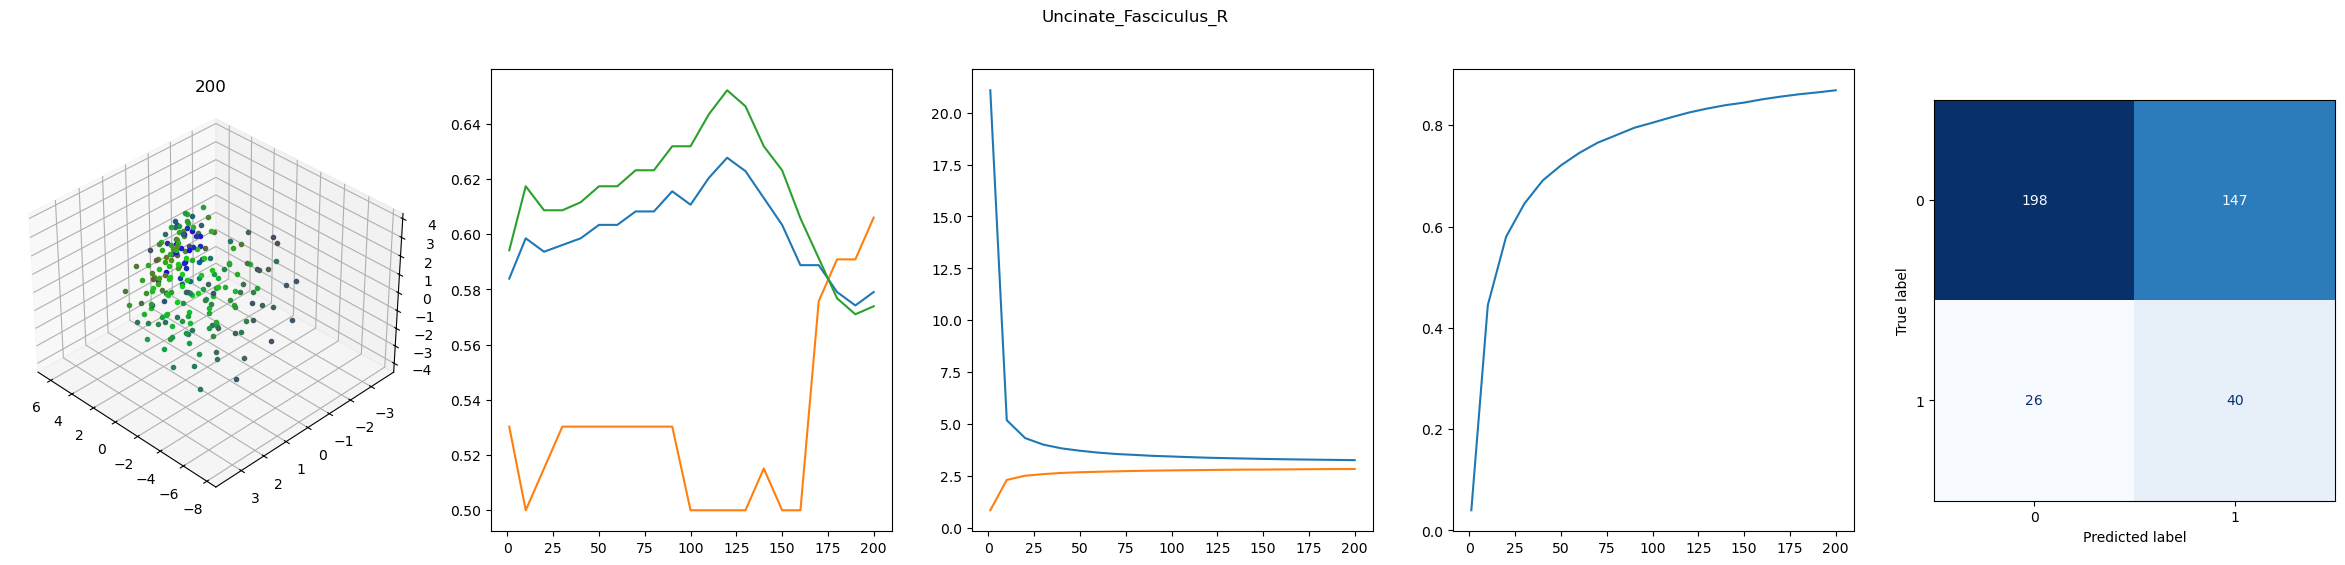

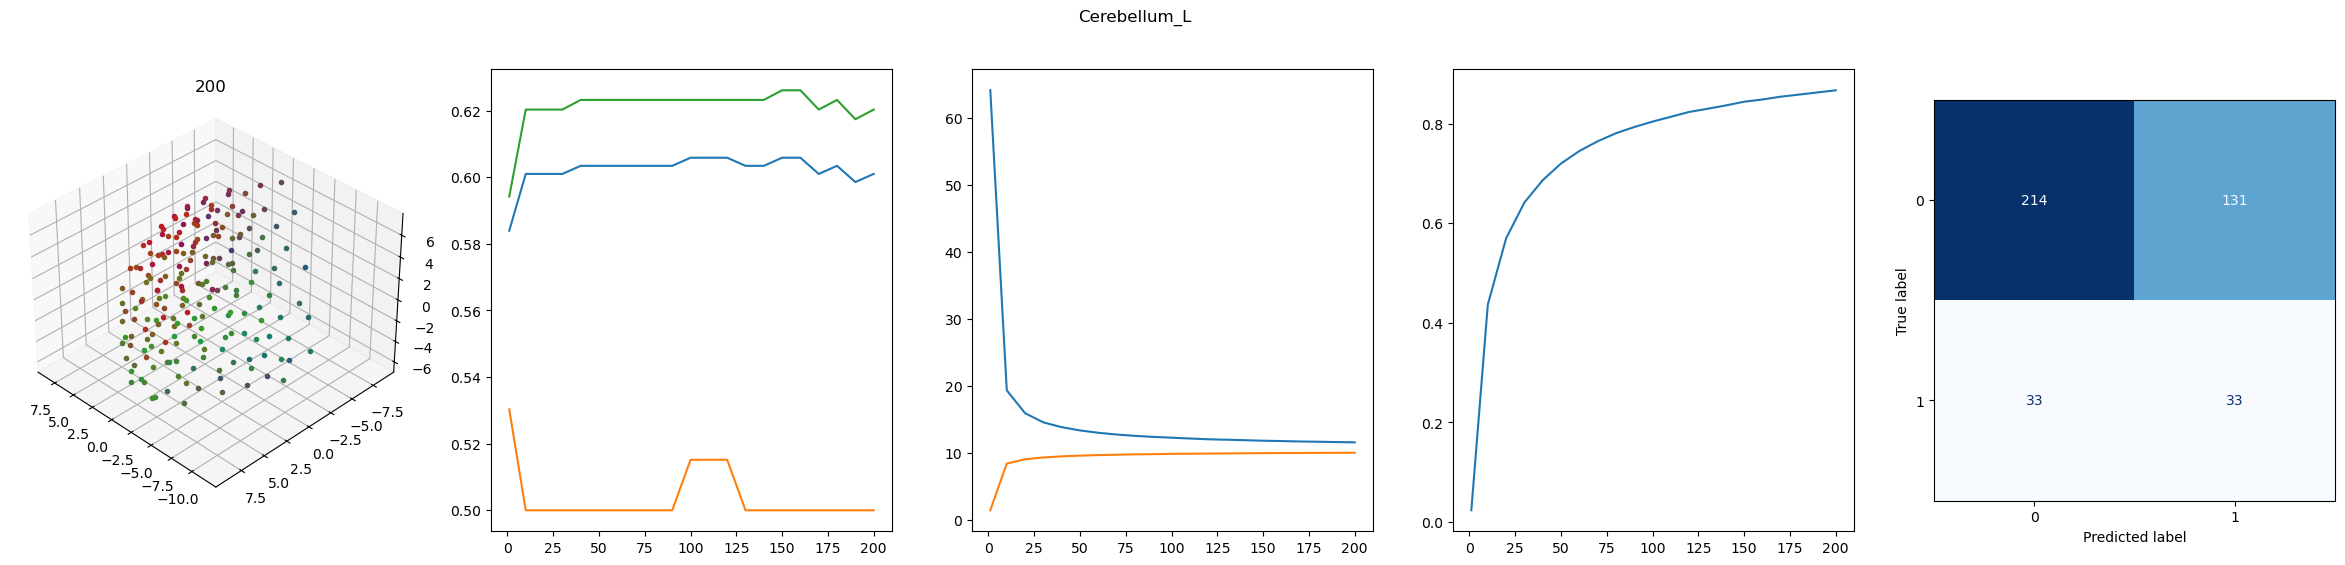

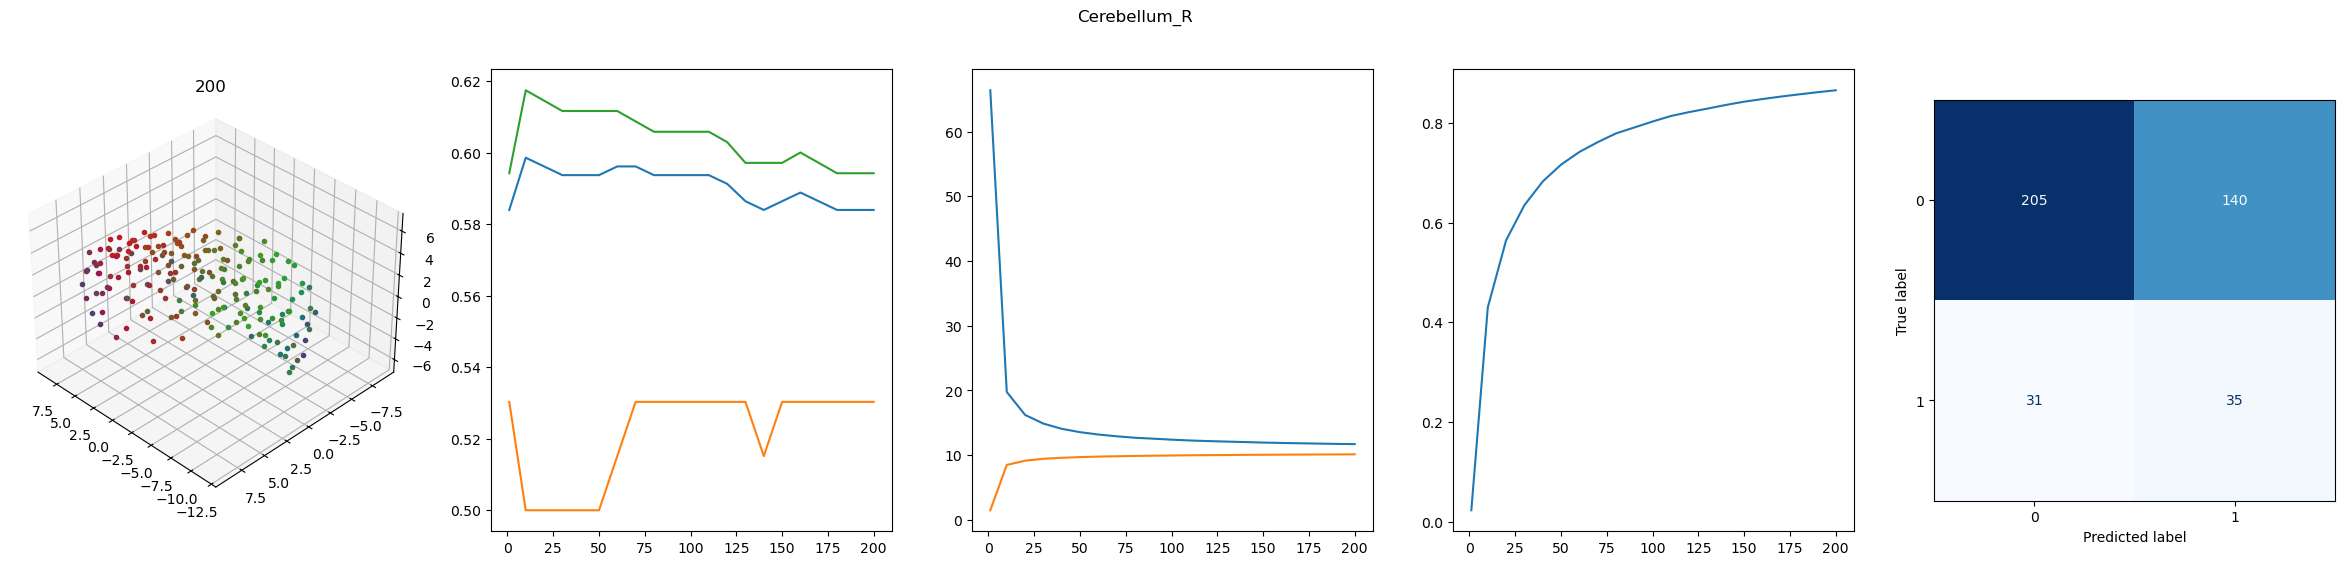

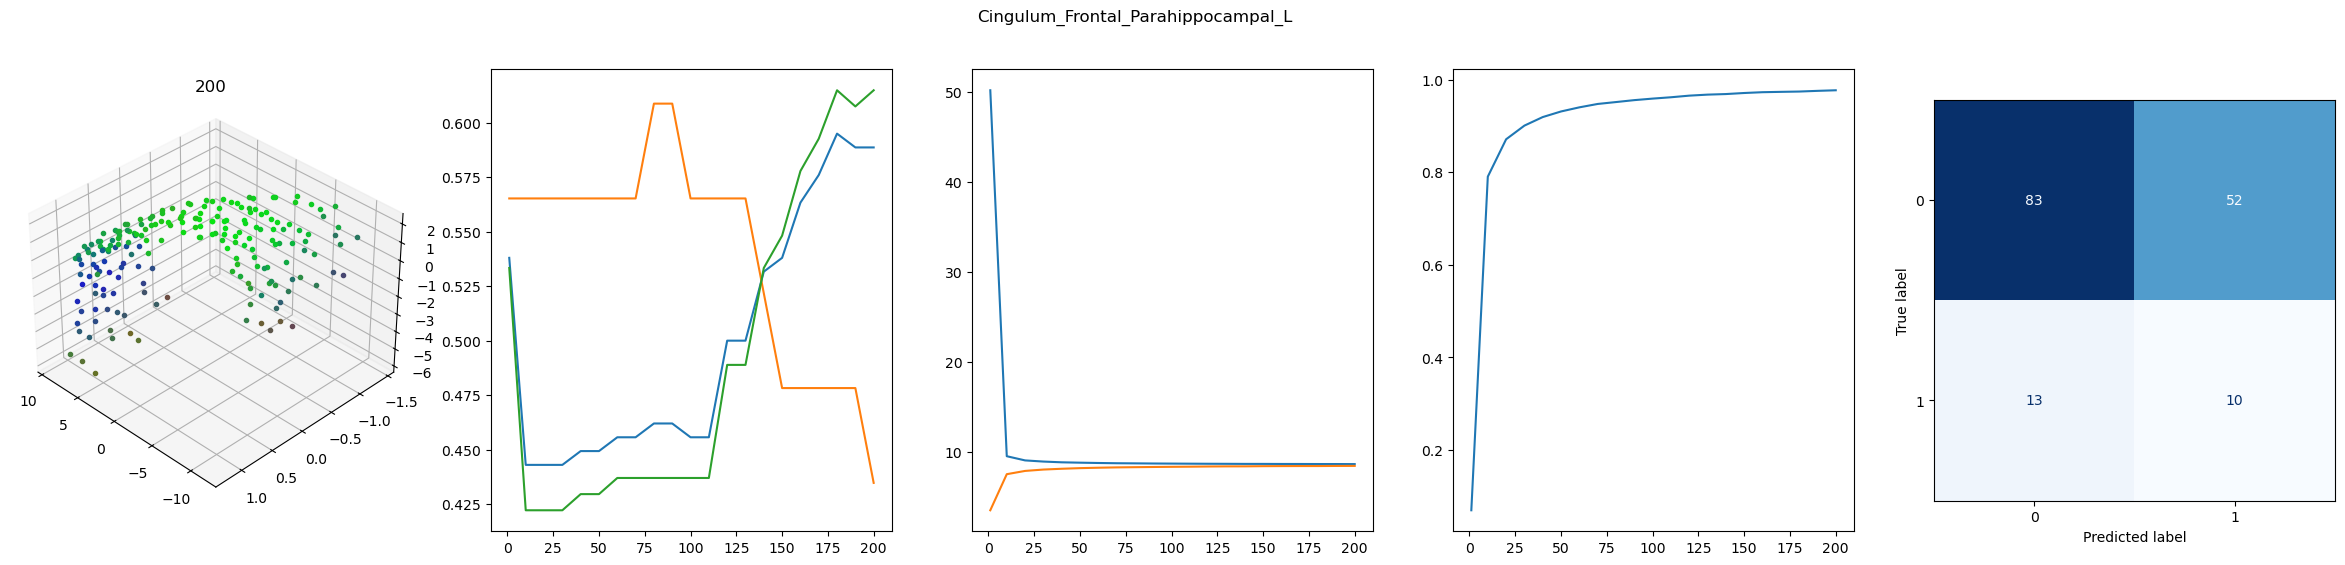

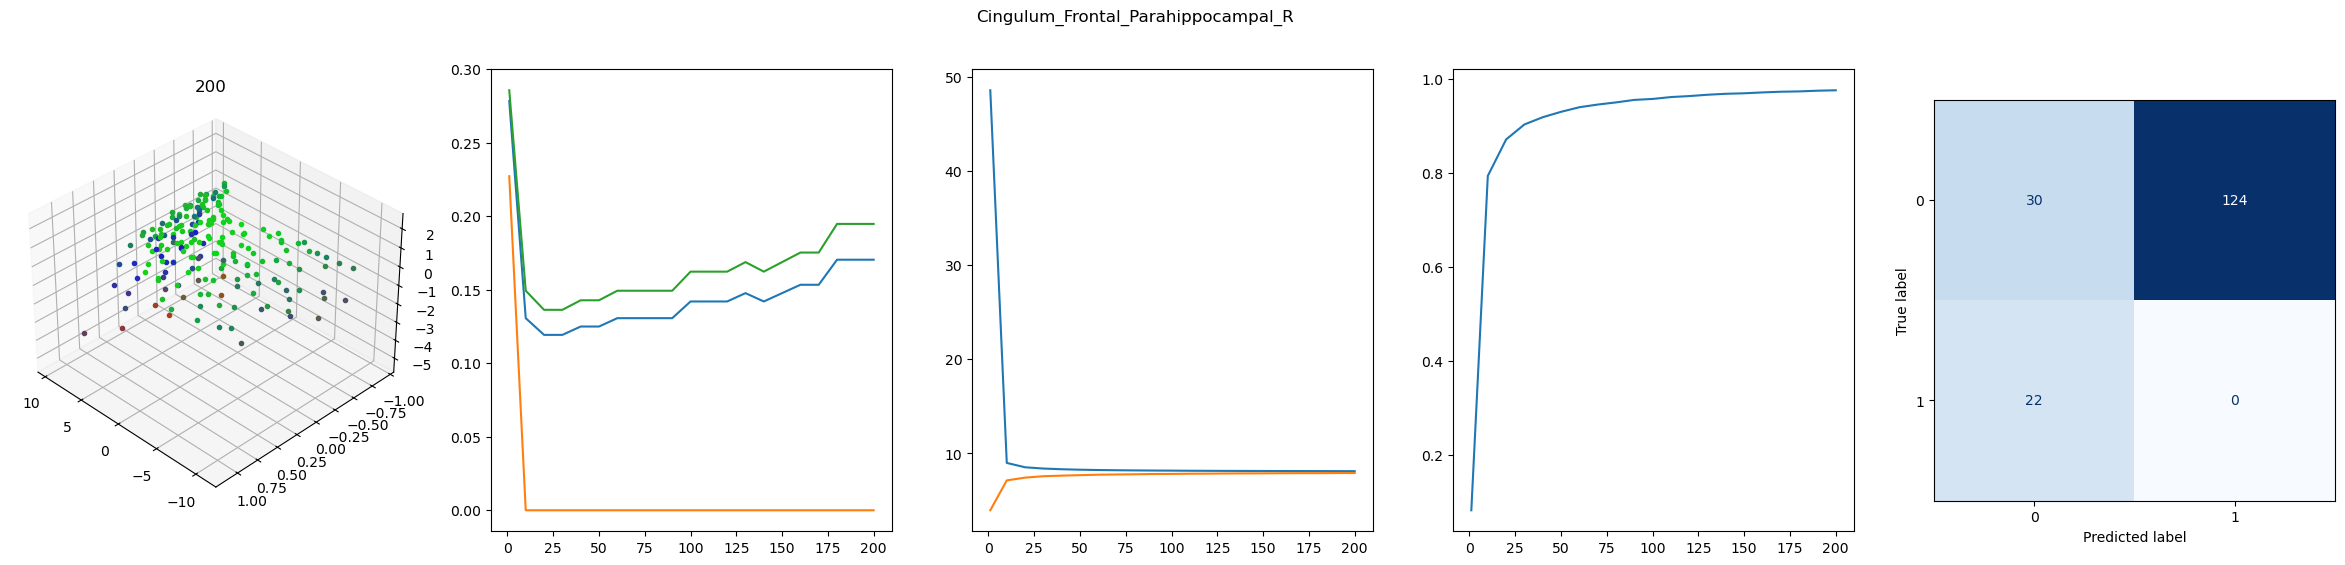

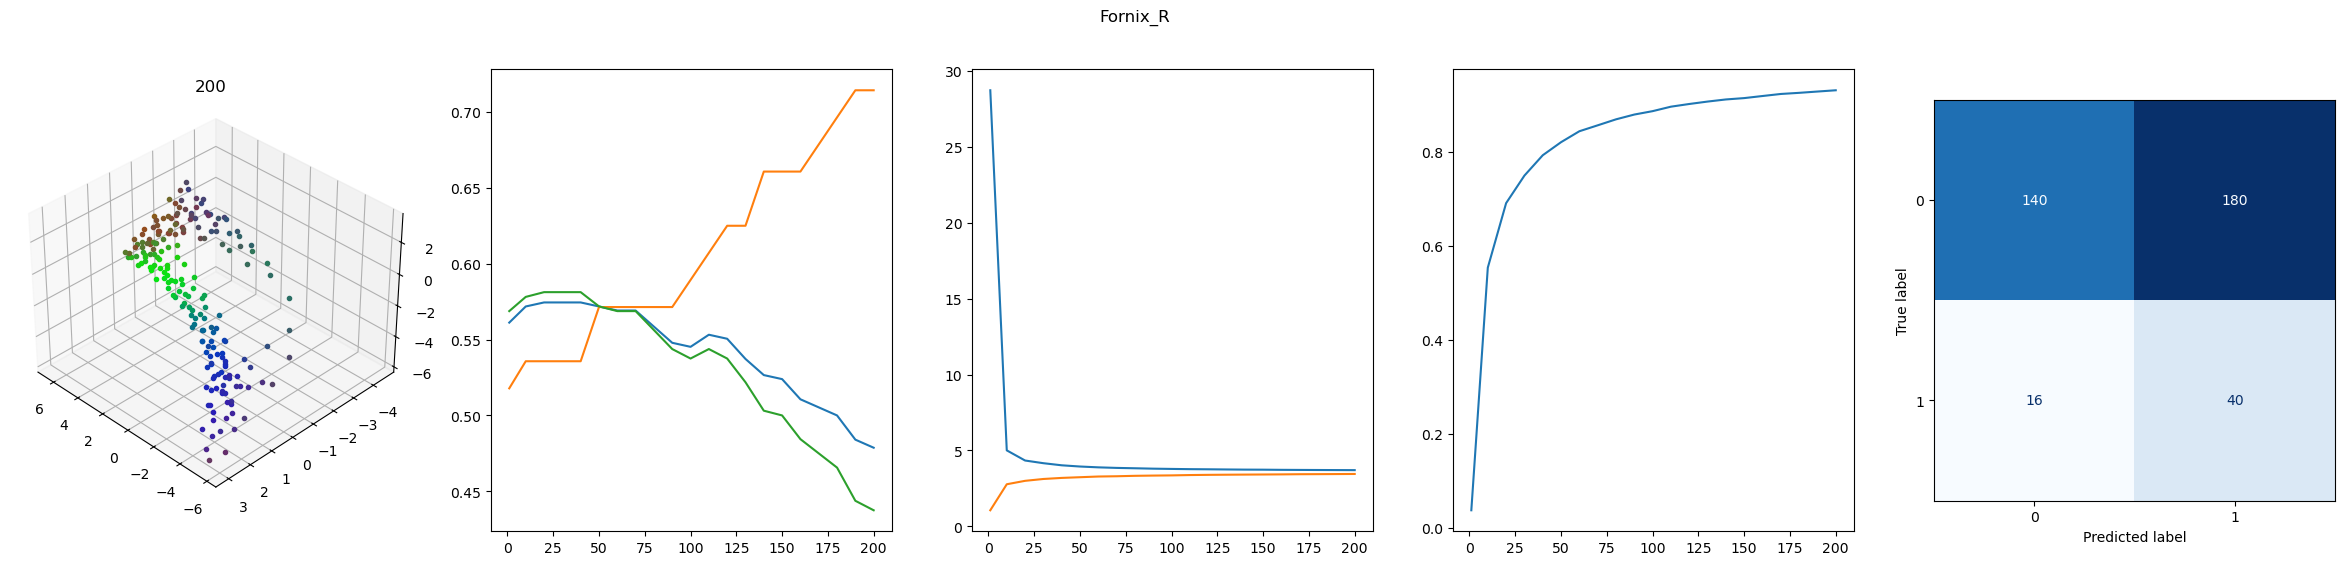

In [21]:
from IPython.display import clear_output

K = np.concatenate((np.array([1]),np.arange(10,201,10)))

tract_list = list(df.columns[7:])

for tract in tract_list:

    #get tract data
    ind = df[tract].dropna().index
    measure_list = list(df[tract][ind])
    dtgmm_list = [DT_GMM_to_dtgmm(measure) for measure in measure_list]
    y = np.array((df['label'][ind]==1).astype(int))
    covariates_temp = covariates[ind]

    acc=np.zeros(len(K))
    prec=np.zeros(len(K))
    prec2=np.zeros(len(K))
    deterministic_component=np.zeros(len(K))
    squared_wasserstein=np.zeros(len(K))

    for i, k in enumerate(K):

        #initialize barycenter with k support points
        barycenter = free_support_barycenter(N=k)

        #fit k-support barycenter to data
        barycenter.fit(dtgmm_list)

        #build classifier
        X = (barycenter.embedding - barycenter.locations)[:,:,3:].reshape(len(y),-1)
        X = np.concatenate((X.T,covariates_temp.T)).T
        temp =  np.mean(cross_val_score(SVC(class_weight='balanced'),X,y,cv=LeaveOneOut()))
        acc[i] = temp
        y_hat = cross_val_predict(SVC(class_weight='balanced'),X,y,cv=LeaveOneOut())
        prec[i] = y_hat[y==1].mean()
        prec2[i] = 1 - y_hat[y==0].mean()

        deterministic_component[i] = np.mean(np.square(np.linalg.norm(barycenter.embedding-barycenter.locations,axis=2))@barycenter.weights)
        squared_wasserstein[i] = np.mean([np.sum(barycenter.M_list[i]*barycenter.Pi_list[i]) for i in range(len(barycenter.M_list))])

    #plot results of classifier and decomposition   
    plt.figure(figsize=(30,6)).add_subplot(151,projection='3d')
    barycenter.plot_gmm()
    plt.gca().view_init(35,135)
    plt.title(str(k))

    plt.subplot(152)
    # plt.plot(K[acc>0],acc[acc>0])
    # plt.plot(K[acc>0],acc[prec>0])
    # plt.plot(K[acc>0],acc[prec2>0])
    plt.plot(K[acc>0],acc[acc>0])
    plt.plot(K[acc>0],prec)
    plt.plot(K[acc>0],prec2)


    plt.subplot(153)
    plt.plot(K, squared_wasserstein)
    plt.plot(K, deterministic_component)

    plt.plot()

    plt.subplot(154)
    plt.plot(K,deterministic_component/(squared_wasserstein+1e-10))

    plt.subplot(155)
    # Compute confusion matrix
    cm = confusion_matrix(y, y_hat)
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.gca(), cmap=plt.cm.Blues, colorbar=False)

    plt.suptitle(tract)
    plt.show()

    np.save("data_files/adni_acc_vs_k_experiment/"+tract+"_y",y)
    np.save("data_files/adni_acc_vs_k_experiment/"+tract+"_y_hat",y_hat)
    np.save("data_files/adni_acc_vs_k_experiment/"+tract+"_accuracy",acc)
    np.save("data_files/adni_acc_vs_k_experiment/"+tract+"_squared_wasserstein",squared_wasserstein)
    np.save("data_files/adni_acc_vs_k_experiment/"+tract+"_deterministic_component",deterministic_component)


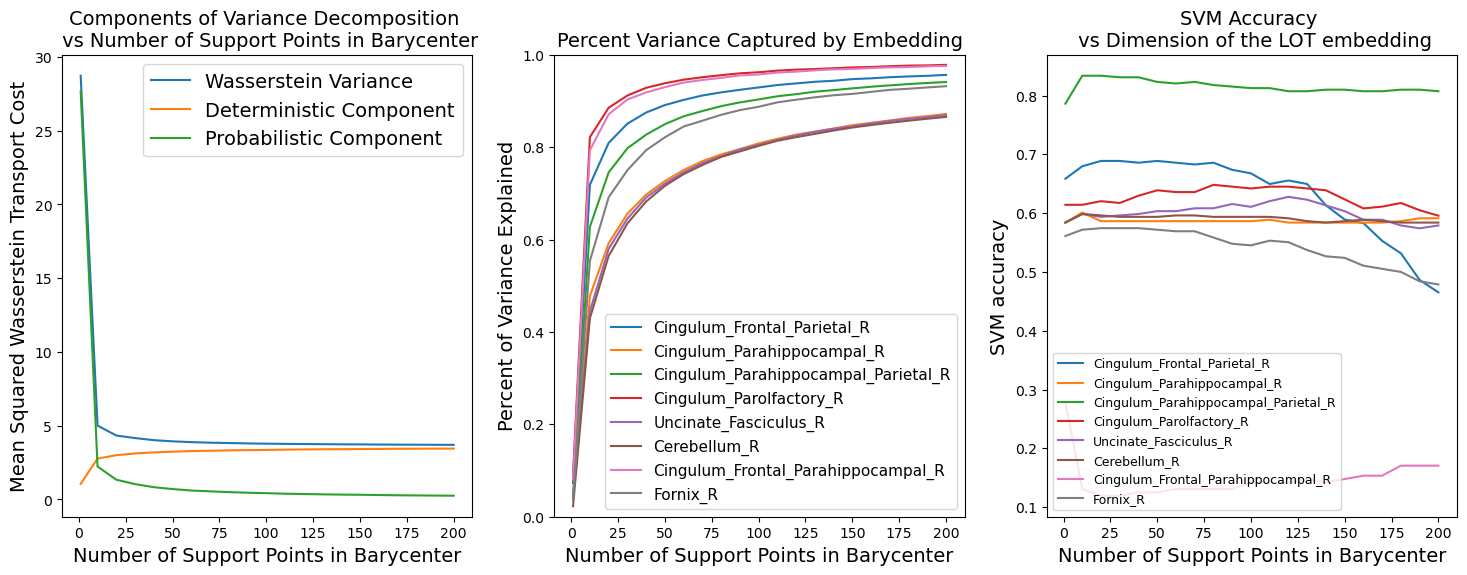

In [57]:
# tract_temp = tract_list

temp = []
import numpy as np
import matplotlib.pyplot as plt

# K = np.concatenate((np.array([1]),np.arange(10,31,10)))#np.concatenate((np.array([1]),np.arange(10,201,10)))

plt.figure(figsize=(18,6))

for tract in tract_list:
    
    acc = np.load("data_files/adni_acc_vs_k_experiment/"+tract+"_accuracy.npy")
    squared_wasserstein = np.load("data_files/adni_acc_vs_k_experiment/"+tract+"_squared_wasserstein.npy")
    deterministic_component = np.load("data_files/adni_acc_vs_k_experiment/"+tract+"_deterministic_component.npy")
    
    if tract[-1]=='R':
               
        if tract=='Fornix_R':
            plt.subplot(131)
            plt.plot(K,squared_wasserstein)
            plt.plot(K,deterministic_component)
            plt.plot(K,squared_wasserstein-deterministic_component)
            plt.legend(("Wasserstein Variance", "Deterministic Component", "Probabilistic Component"), fontsize=14)
            plt.title("Components of Variance Decomposition \n vs Number of Support Points in Barycenter", fontsize=14)
            plt.xlabel("Number of Support Points in Barycenter", fontsize=14)
            plt.ylabel("Mean Squared Wasserstein Transport Cost", fontsize=14)
        
        plt.subplot(132)
        plt.plot(K,deterministic_component/squared_wasserstein)
        plt.title("Percent Variance Captured by Embedding", fontsize=14)
        plt.xlabel("Number of Support Points in Barycenter", fontsize=14)
        plt.ylabel("Percent of Variance Explained", fontsize=14)
        plt.ylim(0,1)
        
        plt.subplot(133)
        plt.plot(K,acc)
        plt.title("SVM Accuracy \n vs Dimension of the LOT embedding", fontsize=14)
        plt.ylabel("SVM accuracy", fontsize=14)
        plt.xlabel("Number of Support Points in Barycenter", fontsize=14)
        
        temp.append(tract)

plt.subplot(132)
plt.legend(temp, fontsize=11)

plt.subplot(133)
plt.legend(temp, fontsize=9)

# plt.show()
plt.savefig("adni_dtmri_experiment",bbox_inches='tight')